In [ ]:
# 1 - setup
import sys
from pathlib import Path
repo_root = Path("..").resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    precision_recall_curve,
    auc
)
from joblib import load
sns.set_theme()
pd.set_option("display.max_columns", None)

# project imports 
from src.data_preprocessing import load_data, run_full_preprocessing
from src.feature_engineering import make_features
from src.supervised_models import train_basic_classifiers, summarize_model_metrics, find_best_threshold
from src.unsupervised_models import fit_isolation_forest, fit_lof, fit_oneclass_svm, eval_unsup_scores
from src.deep_learning_models import train_autoencoder, reconstruction_errors
from src.hybrid_models import weighted_combination, evaluate_combination, cross_validated_hybrid
from src.visualizations import plot_model_summary, plot_unsupervised_compare, plot_ae_history
from src.tuning import tune_randomized, tune_random_forest, tune_logistic, tune_autoencoder_manual, tune_xgboost, tune_gbdt

from src.stacking_oof import fit_stack_oof
from src.unsup_wrappers import iso_wrapper, lof_wrapper
from src.stacking_sklearn import fit_and_evaluate_stack_sklearn
from src.unsup_wrappers import iso_wrapper, lof_wrapper, ocsvm_wrapper


import warnings
warnings.filterwarnings("ignore")

print("Model dev us ready")


Model dev us ready


## **Load and preprocess data**

In [21]:
df = load_data("../data/raw/transactions.csv")

res = run_full_preprocessing(df, target_col="is_fraud", test_size=0.2, val_size=0.2,
                             balance_method="smote", # 'smotetomek', or 'smote', or 'none'
                             save_preprocessor="../artifacts/preprocessor.joblib")

X_train, X_val, X_test = res['X_train'], res['X_val'], res['X_test']
y_train, y_val, y_test = res['y_train'], res['y_val'], res['y_test']


print("saved preprocessor >>>>> artifacts/preprocessor.joblib")


saved preprocessor >>>>> artifacts/preprocessor.joblib


## **Train Supervised Models**

In [22]:
# Train baseline supervised mmodels 
baselines = train_basic_classifiers(X_train, y_train, random_state=42, cv=5)
metrics_df = summarize_model_metrics(baselines, X_train, X_val, y_train, y_val, tune=True)
metrics_df


,model,split,threshold,precision,recall,f1,roc_auc,pr_auc,tn,fp,fn,tp,cv_score
0,logistic,train,0.418885,0.804501,0.982818,0.884764,0.905348,0.835086,443,139,10,572,0.824172
1,logistic,val,0.418885,0.000000,0.000000,0.000000,0.361684,0.021382,149,45,6,0,0.824172
2,random_forest,train,0.665000,1.000000,1.000000,1.000000,1.000000,1.000000,582,0,0,582,0.999021
3,random_forest,val,0.665000,0.000000,0.000000,0.000000,0.394759,0.022219,194,0,6,0,0.999021
4,gbdt,train,0.379776,1.000000,1.000000,1.000000,1.000000,1.000000,582,0,0,582,0.997371
5,gbdt,val,0.379776,0.000000,0.000000,0.000000,0.428694,0.023880,191,3,6,0,0.997371
6,xgboost,train,0.803354,1.000000,1.000000,1.000000,1.000000,1.000000,582,0,0,582,0.998451
7,xgboost,val,0.803354,0.000000,0.000000,0.000000,0.388316,0.022972,194,0,6,0,0.998451
8,svm,train,0.965786,1.000000,1.000000,1.000000,1.000000,1.000000,582,0,0,582,1.000000
9,svm,val,0.965786,0.000000,0.000000,0.000000,0.503866,0.028130,194,0,6,0,1.000000


### **Supervised Models Metrics Visualization**

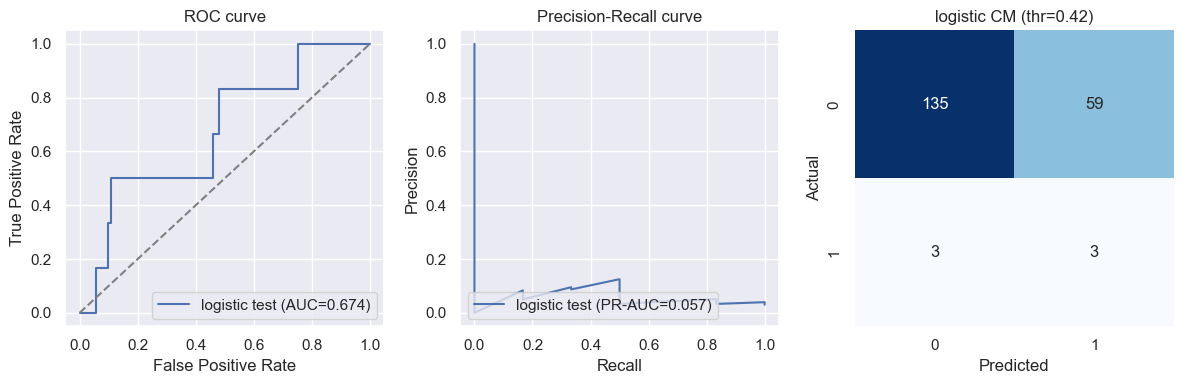

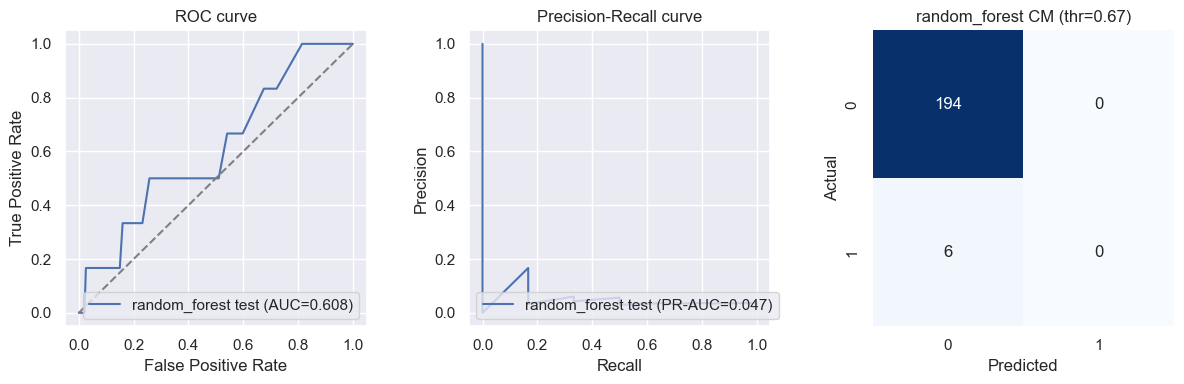

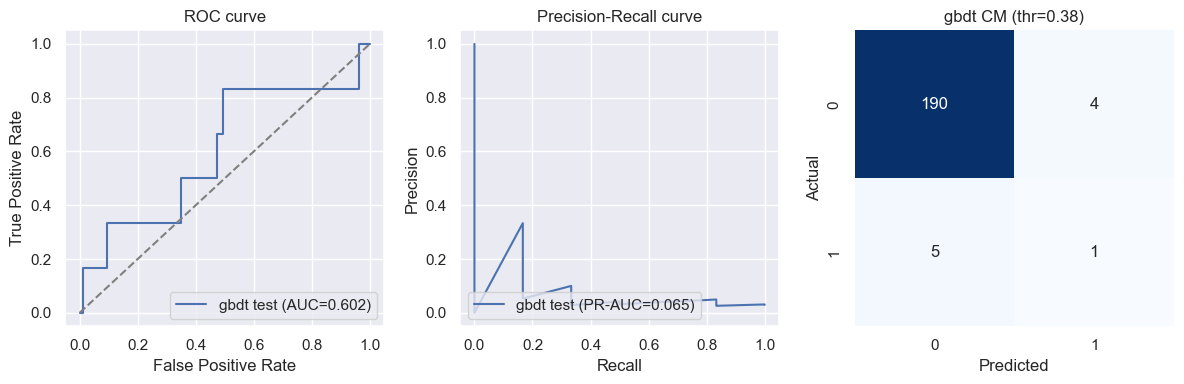

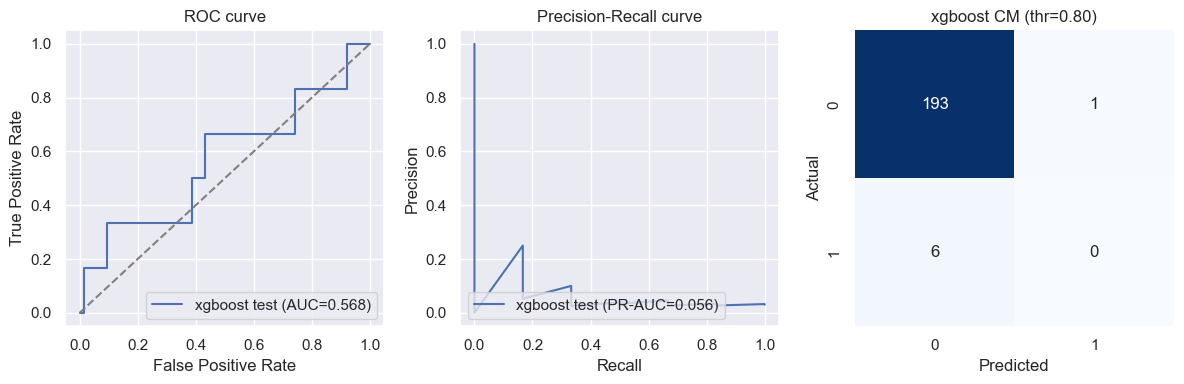

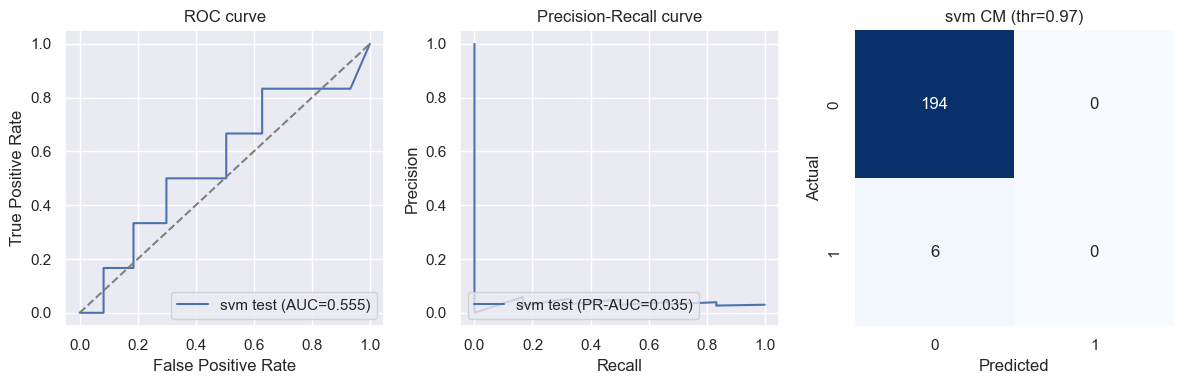

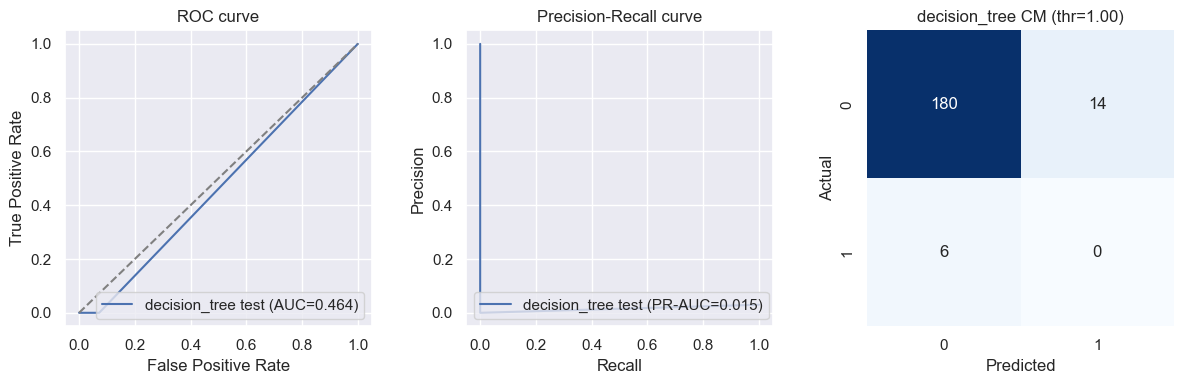

In [23]:
# 1) Plot each supervised model summary (use thresholds tuned earlier or default 0.5)
for model_name in baselines.keys():
    model = baselines[model_name]["model"]
    # compute train/test scores (use earlier X_train/X_test)
    train_scores = model.predict_proba(X_train)[:,1]
    test_scores  = model.predict_proba(X_test)[:,1] 
    thr = find_best_threshold(y_train, train_scores)
    fig = plot_model_summary(model_name, y_train, train_scores, y_test, test_scores, threshold=thr)
    plt.show()

**Takeaways**

* Logistic Regression & Gradient Boosting are the only ones showing any signal.
* But PR-AUC values (<0.07) are extremely low — this reflects the imbalance problem: the models don’t find enough true frauds.

## **Finetune and Evaluate GradientBoosting and Logistic Regression**

**Finetune Gradient Boosting**

In [5]:
# pick scoring appropriate for imbalanced tasks:
scorer = "average_precision"   # prefer PR-AUC for rare-events

gbdt_search = tune_gbdt(X_train.values, y_train.values, n_iter=50, cv=5, scoring=scorer)
print("GBDT best:", gbdt_search.best_params_, "best score:", gbdt_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
GBDT best: {'learning_rate': np.float64(0.29402228054696616), 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 14, 'n_estimators': 172, 'subsample': np.float64(0.5522775798209244)} best score: 0.999666110478034


**Evaluate Gradient Boosting**

In [6]:
# Evaluate best Logistic Regression on test set
test_probs = gbdt_search.predict_proba(X_test)[:,1]
test_preds = (test_probs >= 0.5).astype(int)  # or tune threshold on val then apply
from sklearn.metrics import classification_report, roc_auc_score
print("Test ROC-AUC:", roc_auc_score(y_test, test_probs))
print(classification_report(y_test, test_preds))

Test ROC-AUC: 0.5283505154639175
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       194
           1       0.00      0.00      0.00         6

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.94      0.96      0.95       200



**Finetune Logistic Regression**

In [25]:
# pick scoring appropriate for imbalanced tasks:
scorer = "average_precision"   # prefer PR-AUC for rare-events

logistic_search = tune_logistic(X_train.values, y_train.values,cv=5)
print("logistic Reg best:", logistic_search.best_params_, "best score:", logistic_search.best_score_)

logistic Reg best: {'C': 10.0, 'penalty': 'l2'} best score: 0.8604547394951961


**Evaluate Logistics Regression**

In [26]:
# Evaluate best Logistic Regression on test set
test_probs = logistic_search.predict_proba(X_test)[:,1]
test_preds = (test_probs >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, test_probs))
print(classification_report(y_test, test_preds))

Test ROC-AUC: 0.6520618556701031
              precision    recall  f1-score   support

           0       0.97      0.79      0.88       194
           1       0.05      0.33      0.08         6

    accuracy                           0.78       200
   macro avg       0.51      0.56      0.48       200
weighted avg       0.95      0.78      0.85       200



**Takeaways**

1. Logistic regression is doing something — but the signal is weak. At tuned thresholds, it can start catching some frauds (recall 0.33).
2. Gradient Boosting is essentially blind to fraud in this dataset (under current tuning/feature setup).
3. Precision vs Recall trade-off is real here:
4. High precision means you’ll miss frauds (low recall).
5. High recall means lots of false positives (low precision).

## **Train Unsupervised Models**

In [27]:
# Unsupervised
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test]).astype(int).to_numpy()
iso_m, iso_scores = fit_isolation_forest(X_full.values, contamination=0.02)
lof_m, lof_scores = fit_lof(X_full.values, n_neighbors=20)
oc_m, oc_scores = fit_oneclass_svm(X_full.values, nu=0.02)
print("Iso", eval_unsup_scores(y_full, iso_scores))
print("LOF", eval_unsup_scores(y_full, lof_scores))
print("OCSVM", eval_unsup_scores(y_full, oc_scores))


Iso {'roc_auc': 0.3469782242794025, 'pr_auc': 0.3302055929318318}
LOF {'roc_auc': 0.20421312855038926, 'pr_auc': 0.28773588548662515}
OCSVM {'roc_auc': 0.20670935900133247, 'pr_auc': 0.28809508369709336}


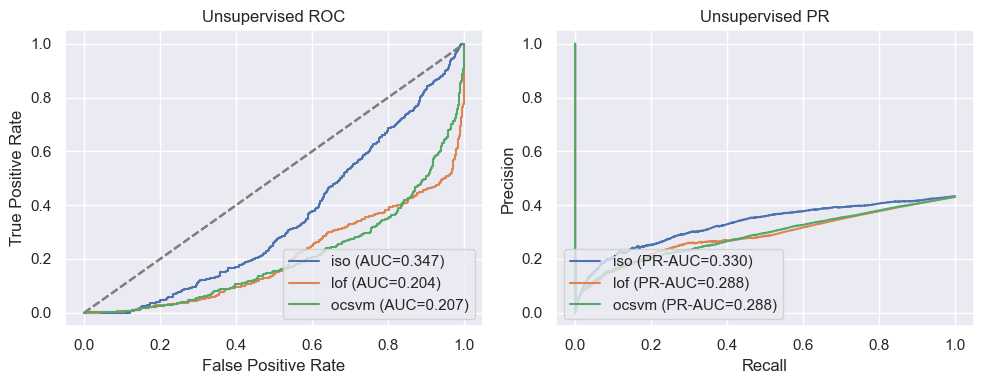

In [8]:
# 2) Unsupervised comparison (iso, lof, ocsvm computed on X_full earlier)
scores_dict = {"iso": iso_scores, "lof": lof_scores, "ocsvm": oc_scores}
fig = plot_unsupervised_compare(y_full, scores_dict)
plt.show()

**Takeaways**

1. All unsupervised methods are failing badly — their ROC-AUCs are below 0.5, which means they’re inverting the intended ranking (frauds look more normal than non-frauds under these anomaly definitions).

2. They do add some weak signal, but on their own they’re not usable.

## **Train Deeplearning Autoencoder**

In [9]:
# Autoencoder
nonfraud = X_full.values[y_full==0]
ae_model, history = train_autoencoder(nonfraud, encoding_dim=32, epochs=12, batch_size=256, verbose=0)
ae_err = reconstruction_errors(ae_model, X_full.values)
print("AE ROC", roc_auc_score(y_full, (ae_err - ae_err.min())/(ae_err.max()-ae_err.min()+1e-12)))


AE ROC 0.31500061364752086


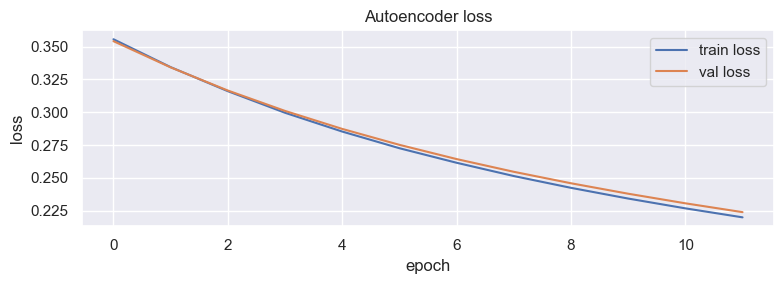

In [10]:
# Autoencoder history
fig = plot_ae_history(history)
plt.show()

* Autoencoder (AE) ROC-AUC = 0.315 is far below the random baseline of 0.5.

> This means that, according to your AE’s reconstruction error, frauds are reconstructed better than normal cases. This means that, the AE is treating frauds as if they were “normal” data.

**Finetuneing Deep Learning (autoencoder)**

In [11]:
# Tune autoencoder
ae_best = tune_autoencoder_manual(X_train, y_train, param_grid={"encoding_dim":[16,32], "lr":[1e-3]}, epochs=12, batch_size=256)
print("AE best encoding_dim:", ae_best['encoding_dim'], "ap:", ae_best['ap'])
ae_model = ae_best['model']
ae_model.save("../artifacts/ae_best.keras")




AE best encoding_dim: 16 ap: 0.43628439747748365


* Best encoding_dim = 16

* Best average precision (AP / PR-AUC) ≈ 0.436

> That’s actually much better than the previous 0.315 ROC-AUC, so the AE is starting to pick up meaningful signals after finetunning

### **Train Hybrid Models**

In [ ]:
# Hybrid setup
sup_model = logistic_search.best_estimator_
sup_scores_full = sup_model.predict_proba(X_full)[:,1]

# Example with iso_scores + ae_scores (if available)
bases = [sup_scores_full, iso_scores]
if "ae_scores" in globals() and ae_scores is not None:
    bases.append(ae_scores)

# Weights
weights = [0.6, 0.3, 0.1]  

# Final hybrid scores
hybrid_scores = weighted_combination(bases, weights=weights)

# Save
joblib.dump({"sup_model": sup_model,
             "unsup_scores": {"iso": iso_scores}, 
             "weights": weights,
             "hybrid_scores": hybrid_scores}, 
            "../artifacts/best_hybrid.joblib")


['../artifacts/best_hybrid.joblib']

In [30]:
sup_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,10.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'liblinear'
,max_iter,2000
,multi_class,'deprecated'


### **Hybrid Models** 

In [ ]:
artifact = joblib.load("../artifacts/best_hybrid.joblib")
hybrid_scores = artifact["hybrid_scores"]

# Extract test part built scores on full data
test_scores = hybrid_scores[len(y_train):]

precision, recall, thresholds = precision_recall_curve(y_test, test_scores)
f1s = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
best_thr = thresholds[f1s.argmax()]

test_preds = (test_scores >= best_thr).astype(int)

print("Hybrid ROC-AUC:", roc_auc_score(y_test, test_scores))
print("Hybrid PR-AUC:", auc(recall, precision))
print("Best threshold:", best_thr)
print(classification_report(y_test, test_preds, digits=3))


Hybrid ROC-AUC: 0.615979381443299
Hybrid PR-AUC: 0.05628721970833678
Best threshold: 0.6895508321531574
              precision    recall  f1-score   support

           0      0.978     0.933     0.955       194
           1      0.133     0.333     0.190         6

    accuracy                          0.915       200
   macro avg      0.556     0.633     0.573       200
weighted avg      0.953     0.915     0.932       200



* Hybrid helps a little: better than random, but still struggles on minority class.
* Precision is very low for frauds (13%): most predicted frauds are actually legit.
* Recall is modest (33%): catches only 2 out of 6 frauds.

> Threshold tuning matters: precision@k will be explored to flag top suspicious transactions flagged instead of fixed threshold.

## **Stacking Models**

**Simple scikit-learn Stacking implementation**

In [ ]:
# Sklearn stacking (supervised only)
res = fit_and_evaluate_stack_sklearn(X_train, y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test)
print("Sklearn stacking metrics (test):", res['preds'].get('test', {}).get('metrics'))

Sklearn stacking metrics (test): {'roc_auc': 0.5902061855670103, 'pr_auc': 0.06143057029224057}


* ROC-AUC = 0.590

1. Slightly above random (0.5). Not great, but consistent with how tough your fraud dataset is.

2. It’s a bit worse than hybrid ensemble (0.616).

* PR-AUC = 0.061

1. Baseline PR-AUC ≈ fraud prevalence = 0.03 (since ~3% fraud rate).

> Stacker is just about double random guessing — not amazing, lbut shows some signal.

**Custom Out-of-Fold stacking**

In [33]:
out = fit_stack_oof(X_train, y_train, X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test,
                    include_unsup=True, unsup_funcs=[iso_wrapper, lof_wrapper],
                    ae_errors_train=None, ae_errors_full=None)
print(out['test_meta_metrics'])

{'roc_auc': 0.5378006872852232, 'pr_auc': 0.048907550951947334}


OOF stacking run gave:
* ROC-AUC = 0.538 → Only a hair above random (0.50).
* PR-AUC = 0.049 → That’s basically at the level of random guessing (baseline ~0.03 since fraud rate ≈3%).

**CONCLUSION**

**The meta-model (stacker) didn’t learn much signal.**

Likely causes:

1. Unsupervised scores (Iso/LOF/OCSVM/AE) are very noisy — their individual ROC-AUCs ~0.2–0.35. Feeding them directly may confuse the stacker.

2. Supervised base models (logistic, RF, GBDT, XGB, etc.) didn’t perform strongly either, so the stacker has weak ingredients.

3. Because of the low fraud prevalence (~3%), the stacker failed to predict almost all 0’s.

**Compare to other approaches**

* Best Hybrid: ROC-AUC ~0.616, PR-AUC ~0.056.

* Sklearn Stacking: ROC-AUC ~0.590, PR-AUC ~0.061.

* OOF Stacking: ROC-AUC ~0.538, PR-AUC ~0.049.

> So far, Hybrid ensemble wins. So precision@k will be explored to flag top suspicious transactions flagged instead of fixed threshold.